In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns
import pycountry as pc

In [2]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores
def analysis(uni19_df):
    uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
    uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
    uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(uni19_df.loc[:, 'Sending Organization' ]), set(uni19_df.loc[:, 'Receiving Organization']))))
    uni19_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    uni19_df['SendId'] = (np.array(list(map(lambda x: node_position[x], uni19_df['Sending Organization']))))
    uni19_df['RecId']= (np.array(list(map(lambda x: node_position[x], uni19_df['Receiving Organization']))))
    # Adjacency matrix
    country_serie = uni19_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))


    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    uni19_df.rename({'Sending Organization': 'source', 'Receiving Organization':'target', 'Participants':'weight'},axis=1, inplace=True)
    components = ns.find_components(adj_matrix_crs, nodes_df)
    unique, counts = np.unique(components['component'], return_counts=True)
    print('Number of components =', len(unique))
    scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
    ns.display_top_n(scores, 10, 'in degree')
    ns.display_top_n(scores, 10, 'out degree')
    df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')
    ns.display_top_n(scores, 10, 'hits hub')
    ns.display_top_n(scores, 10, 'hits autority')
    df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')

    ns.display_top_n(scores, 10, 'PageRank hub')
    ns.display_top_n(scores, 10, 'PageRank autority')

    sns.pairplot(scores)
    plt.show()
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits autority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank autority')
    scores.sort_index(inplace=True)
    n = 40
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank autority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank autority', 'PageRank autority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    edges = uni19_df[['source','target']].copy()
    print(ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True))
    # label = 'PageRank autority position'
    label = 'in degree position'
    c = uni19_df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'weight']]
    c_serie = c.groupby(['source ID', 'target ID']).sum()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    ns.visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()

In [3]:
def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

In [17]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
city_df = pd.read_csv('data\worldcities.csv', sep=',', low_memory=False, header=0, encoding= 'utf8')
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
uni19_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), uni19_df['Receiving Country Code']))))
uni19_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), uni19_df['Sending Country Code']))))
mob_df = uni19_df.rename(columns={'Sending Organization': 'Source','Receiving Organization': 'Target', 'Participants':'weight', 'Sending Country Code': 'country'})
node_df = mob_df.iloc[:, [15,17]].drop_duplicates(subset='Source')
labels = list(range(0,4339))
node_df['source'] = labels
mob = mob_df.rename(columns={'Source': 'Target'})
node_df1 = mob.iloc[:, [15,17]].drop_duplicates(subset='Target')
node_df1["target"] = labels
results = pd.merge(mob_df,node_df, how='inner', on='Source')
results = pd.merge(results, node_df1, how='inner', on='Target')
edges_df = results.iloc[:, [27,25,23]].groupby(['source','target']).sum()
edges_df.to_csv('edges_universities1.csv')
node = pd.DataFrame()
node['Source'] = mob_df['Source'].unique()
nodes = mob_df.iloc[:, [15,16,17]].drop_duplicates(subset='Source')
#nodes = pd.merge(node,node1,how='left',on='Source').drop_duplicates(subset='Source')
city_df.rename(columns={'city_ascii':'Sending City'}, inplace=True)
city_df['Sending City'] = city_df['Sending City'].str.lower()
nodes['Sending City'] = nodes['Sending City'].str.lower()
city_df = city_df.iloc[:,[1,2,3,7]]
nodes2 = pd.merge(nodes,city_df,how='left',on='Sending City')
nodes2.drop_duplicates(subset='Source', inplace=True)
nodes2['id'] = labels
nodes2.to_csv('nodes_universities1.csv')
nodes2

,country,Sending City,Source,lat,lng,admin_name,id
0,China,beijing,China Foreign Affairs University,39.9050,116.3914,Beijing,0
1,Austria,wien,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,48.2083,16.3731,Wien,1
2,Russian Federation,rostov on don,SOUTHERN FEDERAL UNIVERSITY,NaN,NaN,NaN,2
3,Russian Federation,saint petersburg,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,59.9500,30.3167,Sankt-Peterburg,3
4,Austria,wien,UNIVERSITAT WIEN,48.2083,16.3731,Wien,4
...,...,...,...,...,...,...,...
6185,UK,dunbeg oban,THE SCOTTISH ASSOCIATION FOR MARINESCIENCE LBG,NaN,NaN,NaN,4334
6186,UK,london,BIRKBECK COLLEGE - UNIVERSITY OF LONDON,51.5072,-0.1275,"London, City of",4335
6190,UK,london,IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MED...,51.5072,-0.1275,"London, City of",4336
6194,UK,london,REGENT'S UNIVERSITY LONDON LIMITED,51.5072,-0.1275,"London, City of",4337


In [5]:
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
nodes = np.array(list(set.union(set(uni19_df.loc[:, 'Sending Organization' ]), set(uni19_df.loc[:, 'Receiving Organization']))))
uni19_df.dropna(how='any', inplace=True)
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Source': nodes})
uni19_df['SendId'] = (np.array(list(map(lambda x: node_position[x], uni19_df['Sending Organization']))))
uni19_df['RecId']= (np.array(list(map(lambda x: node_position[x], uni19_df['Receiving Organization']))))
# Adjacency matrix
country_serie = uni19_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

In [6]:
import networkx as nx

# G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs, create_using= nx.DiGraph)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

In [7]:
uni19_df = uni19_df[uni19_df['Participant Profile']=='Learner']
uni19_df = uni19_df[uni19_df['Activity (mob)'].str.contains('Student')]
uni19_df = uni19_df[~uni19_df['Activity (mob)'].str.contains('traineeship')]
df_w_fields = uni19_df.loc[:,['Field of Education','Sending Organization','Participants']]
df_w_fields.rename(columns={'Sending Organization':'Source'}, inplace=True)
df_w_fields = pd.merge(df_w_fields,nodes_df,how='inner',on='Source')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not further defined','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', inter-disciplinary programmes','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not elsewhere classified','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(' not elsewhere classified','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not elsewhere classifed','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace('Inter-disciplinary programmes and qualifications involving ','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.lower()
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.strip()
field_dic = {'Education': ['training for pre-school teachers','teacher training without subject specialization','teacher training with subject specialization','education','education science'],
                'Arts and humanities': ['handicrafts','religion and theology','philosophy and ethics','music and performing arts','literature and linguistics','languages','language acquisition','humanities (except languages)','history and archaeology','fine arts','fashion, interior and industrial design','arts', 'arts and humanities', 'audio-visual techniques and media production'],
                'Social sciences': ['sociology and cultural studies','social sciences, journalism and information','social and behavioural sciences','psychology','political sciences and civics','library, information and archival studies','journalism and reporting','journalism and information','economics'],
                'Business, administration and law': ['work skills','wholesale and retail sales','marketing and advertising','management and administration','law','finance, banking and insurance','business, administration and law', 'business and administration', 'accounting and taxation'],
                'Sciences, mathematics and statistics': ['statistics','physics','physical sciences','natural sciences, mathematics and statistics','natural environments and wildlife','mathematics and statistics','mathematics','environmental sciences','environment','earth sciences','chemistry', 'biochemistry', 'biological and related sciences', 'biology'],
                'ICT': ['software and applications development and analysis','information and communication technologies (icts)','database and network design and administration', 'computer use'],
                'Engineering, manufacturing and construction': ['textiles (clothes, footwear and leather)','motor vehicles, ships and aircraft','mining and extraction','mechanics and metal trades','materials (glass, paper, plastic and wood)','manufacturing and processing','food processing','environmental protection technology','electronics and automation','engineering and engineering trades','engineering, manufacturing and construction','electricity and energy','chemical engineering and processes', 'architecture and construction', 'architecture and town planning', 'building and civil engineering'],
                'Agriculture, forestry and veterinary': ['veterinary','forestry','fisheries','crop and livestock production', 'agriculture', 'agriculture, forestry, fisheries and veterinary'],
                'Health and welfare': ['welfare','traditional and complementary medicine and therapy','therapy and rehabilitation','pharmacy','nursing and midwifery','medicine','medical diagnostic and treatment technology','hygiene and occupational health services','horticulture','health and welfare','health','dental studies', 'child care and youth services', 'care of the elderly and of disabled adults'],
                'Services': ['travel, tourism and leisure','transport services','sports','social work and counselling','services','security services','secretarial and office work','protection of persons and property','personal services','occupational health and safety','military and defence','hotel, restaurants and catering','hair and beauty services','domestic services','community sanitation']
                }
                
def standard_field(field):
    for f in field_dic.keys():
        if field in field_dic[f]:
            return f

df_w_fields['Field of Education'] = df_w_fields['Field of Education'].apply(standard_field)
df_w_fields['Community']=np.zeros(len(df_w_fields.index),dtype='int8')

,Field of Education,Source,Participants,Community
0,Social sciences,China Foreign Affairs University,1,0
4,Arts and humanities,China Foreign Affairs University,1,0
7,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,0
12,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,0
15,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,0
...,...,...,...,...
234346,Services,UNIVERSITY COLLEGE BIRMINGHAM,1,0
234347,"Business, administration and law",UNIVERSITY COLLEGE BIRMINGHAM,1,0
234348,"Business, administration and law",UNIVERSITY COLLEGE BIRMINGHAM,1,0
234349,Services,UNIVERSITY COLLEGE BIRMINGHAM,1,0


,Field of Education,Source,Participants,Community
2,Arts and humanities,China Foreign Affairs University,1,1
3,Arts and humanities,China Foreign Affairs University,1,1
6,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
8,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
9,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,1
...,...,...,...,...
5389,Social sciences,VRIJE UNIVERSITEIT BRUSSEL,1,1
5390,"Sciences, mathematics and statistics",VRIJE UNIVERSITEIT BRUSSEL,1,1
5391,"Engineering, manufacturing and construction",VRIJE UNIVERSITEIT BRUSSEL,1,1
5395,Social sciences,VRIJE UNIVERSITEIT BRUSSEL,1,1


,Field of Education,Source,Participants,Community
1,Arts and humanities,China Foreign Affairs University,1,2
5,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,2
10,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,2
13,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,2
17,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,2
...,...,...,...,...
5387,Social sciences,VRIJE UNIVERSITEIT BRUSSEL,1,2
5388,Social sciences,VRIJE UNIVERSITEIT BRUSSEL,1,2
5396,"Business, administration and law",VRIJE UNIVERSITEIT BRUSSEL,1,2
5405,Social sciences,VRIJE UNIVERSITEIT BRUSSEL,1,2


,Field of Education,Source,Participants,Community
29,"Business, administration and law",FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,3
77,"Business, administration and law",FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,1,3
84,"Business, administration and law",FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,2,3
100,"Business, administration and law",UNIVERSITAT WIEN,1,3
108,Arts and humanities,UNIVERSITAT WIEN,1,3
...,...,...,...,...
5244,Social sciences,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,3
5341,ICT,SFAX UNIVERSITY,1,3
5358,"Sciences, mathematics and statistics",VRIJE UNIVERSITEIT BRUSSEL,1,3
5394,"Business, administration and law",VRIJE UNIVERSITEIT BRUSSEL,1,3


,Field of Education,Source,Participants,Community
61,ICT,SOUTHERN FEDERAL UNIVERSITY,1,4
115,"Business, administration and law",UNIVERSITAT WIEN,1,4
121,Health and welfare,UNIVERSITAT WIEN,1,4
165,"Sciences, mathematics and statistics",UNIVERSITAT WIEN,1,4
212,Arts and humanities,UNIVERSITAT WIEN,1,4
...,...,...,...,...
5365,Social sciences,VRIJE UNIVERSITEIT BRUSSEL,1,4
5368,"Sciences, mathematics and statistics",VRIJE UNIVERSITEIT BRUSSEL,1,4
5374,Health and welfare,VRIJE UNIVERSITEIT BRUSSEL,1,4
5392,"Engineering, manufacturing and construction",VRIJE UNIVERSITEIT BRUSSEL,1,4


4338


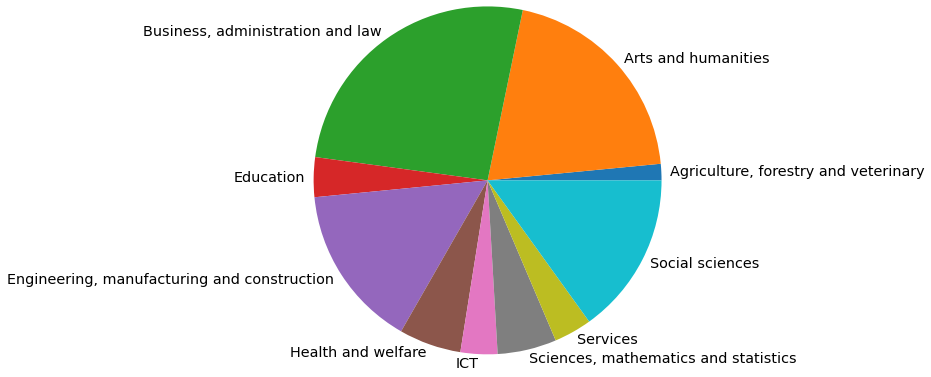

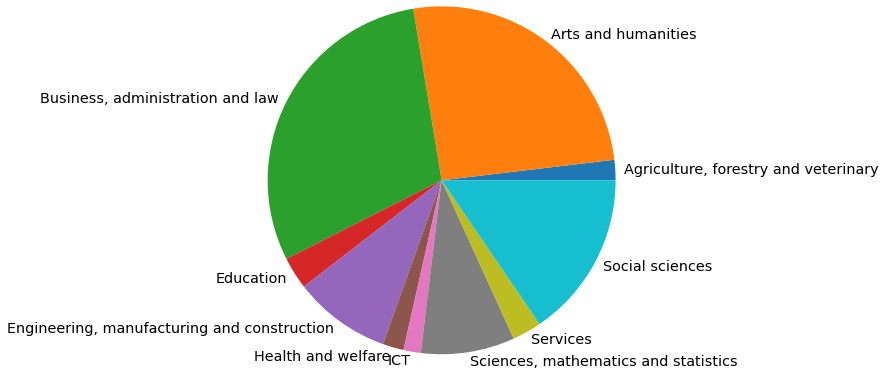

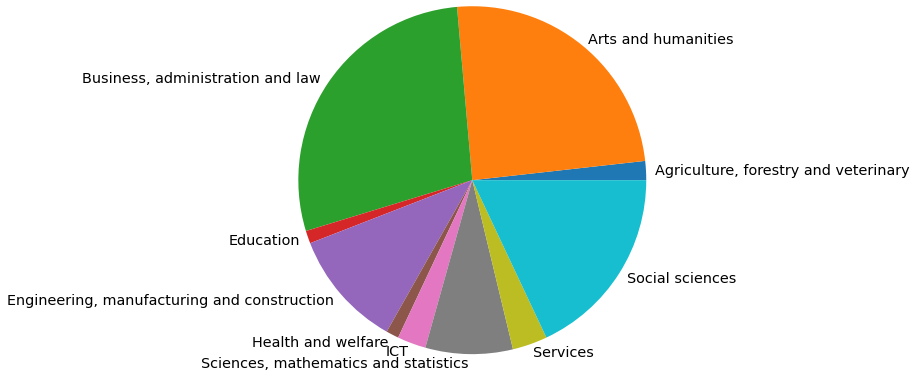

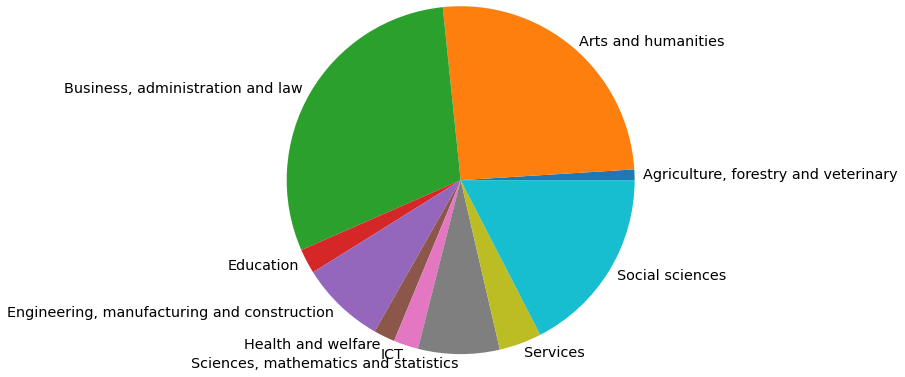

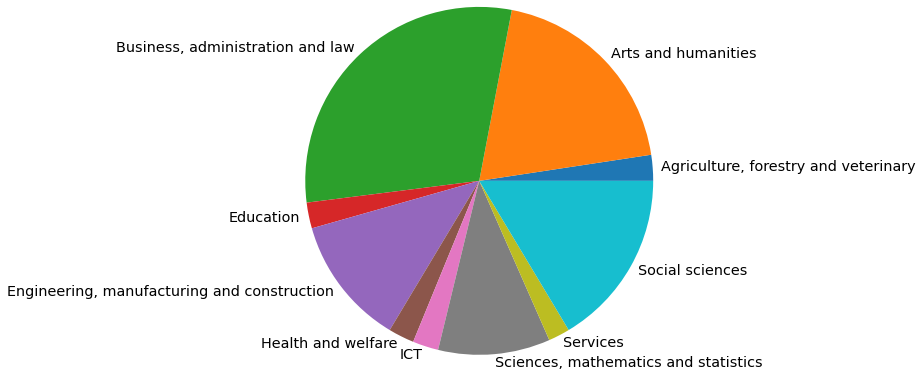

In [8]:
for i, set in enumerate(p):
    for element in set:
        df_w_fields.iat[element, 3]=i
for i, set in enumerate(p):
    if(len(df_w_fields[df_w_fields['Community']==i].index)>100):
        display(df_w_fields[df_w_fields['Community']==i])
print(df_w_fields['Source'].nunique())


for i, set in enumerate(p):
    if(len(df_w_fields[df_w_fields['Community']==i].index)>100):
        com_df = df_w_fields[df_w_fields['Community']==i]
        label = com_df.groupby(['Field of Education']).sum().index.get_level_values('Field of Education').tolist()
        com_df = com_df.groupby(['Field of Education']).sum()
        #display(com_df)
        values = com_df['Participants']
        #com_df = com1_df['Quantity']/1318*100
        plt.pie(values,labels= label, labeldistance=1.05,radius=2, textprops={'size':'x-large'})
        plt.show()

,country,Source,Participants,Community
5,Austria,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,0
6,Austria,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,0
7,Austria,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,0
8,Austria,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,0
9,Austria,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,0
...,...,...,...,...
234162,Turkey,ESKISEHIR TEKNIK UNIVERSITESI,1,0
234163,Turkey,ESKISEHIR TEKNIK UNIVERSITESI,1,0
234164,Turkey,ESKISEHIR TEKNIK UNIVERSITESI,1,0
234165,Turkey,ESKISEHIR TEKNIK UNIVERSITESI,1,0


,country,Source,Participants,Community
89,Austria,UNIVERSITAT WIEN,1,1
90,Austria,UNIVERSITAT WIEN,1,1
91,Austria,UNIVERSITAT WIEN,1,1
92,Austria,UNIVERSITAT WIEN,1,1
93,Austria,UNIVERSITAT WIEN,1,1
...,...,...,...,...
234180,Turkey,ISTANBUL UNIVERSITESI - CERRAHPASA,1,1
234181,Turkey,ISTANBUL UNIVERSITESI - CERRAHPASA,1,1
234182,Turkey,ISTANBUL UNIVERSITESI - CERRAHPASA,1,1
234183,Turkey,ISTANBUL UNIVERSITESI - CERRAHPASA,1,1


,country,Source,Participants,Community
7957,Czechia,OSTRAVSKA UNIVERZITA,1,2
7958,Czechia,OSTRAVSKA UNIVERZITA,1,2
7959,Czechia,OSTRAVSKA UNIVERZITA,1,2
7960,Czechia,OSTRAVSKA UNIVERZITA,1,2
7961,Czechia,OSTRAVSKA UNIVERZITA,1,2
...,...,...,...,...
233691,Poland,Collegium Da Vinci,1,2
233692,Poland,Collegium Da Vinci,1,2
233693,Poland,Collegium Da Vinci,1,2
233694,Poland,Collegium Da Vinci,1,2


,country,Source,Participants,Community
3576,Montenegro,University of Donja Gorica,1,3
3577,Montenegro,University of Donja Gorica,1,3
3635,Austria,MONTANUNIVERSITAT LEOBEN,1,3
3636,Austria,MONTANUNIVERSITAT LEOBEN,1,3
3637,Austria,MONTANUNIVERSITAT LEOBEN,1,3
...,...,...,...,...
233584,Latvia,National Defence Academy of Latvia,1,3
233585,Latvia,National Defence Academy of Latvia,1,3
233586,Latvia,National Defence Academy of Latvia,1,3
233623,North Macedonia,Republika Makedonija Univerzitet Goce Delchev ...,1,3


,country,Source,Participants,Community
2444,Ukraine,CHERNIVTSI NATIONAL UNIVERSITY YURIY FEDKOVYCH,2,4
2445,Ukraine,CHERNIVTSI NATIONAL UNIVERSITY YURIY FEDKOVYCH,1,4
2446,Ukraine,CHERNIVTSI NATIONAL UNIVERSITY YURIY FEDKOVYCH,1,4
2447,Ukraine,CHERNIVTSI NATIONAL UNIVERSITY YURIY FEDKOVYCH,1,4
2448,Ukraine,CHERNIVTSI NATIONAL UNIVERSITY YURIY FEDKOVYCH,1,4
...,...,...,...,...
233637,Norway,DRONNING MAUDS MINNE HØGSKOLE FOR BARNEHAGELÆR...,1,4
233638,Norway,DRONNING MAUDS MINNE HØGSKOLE FOR BARNEHAGELÆR...,2,4
233639,Norway,DRONNING MAUDS MINNE HØGSKOLE FOR BARNEHAGELÆR...,1,4
233640,Norway,DRONNING MAUDS MINNE HØGSKOLE FOR BARNEHAGELÆR...,1,4


,country,Source,Participants,Community
19193,Albania,UNIVERSITETI I MJEKESISE TIRANE,2,5
19194,Albania,UNIVERSITETI I MJEKESISE TIRANE,1,5
19195,Albania,UNIVERSITETI I MJEKESISE TIRANE,1,5
19196,Albania,UNIVERSITETI I MJEKESISE TIRANE,1,5
19197,Albania,UNIVERSITETI I MJEKESISE TIRANE,1,5
...,...,...,...,...
210514,Romania,UNIVERSITATEA DE MEDICINA SI FARMACIE DIN CRAIOVA,1,5
210515,Romania,UNIVERSITATEA DE MEDICINA SI FARMACIE DIN CRAIOVA,1,5
210516,Romania,UNIVERSITATEA DE MEDICINA SI FARMACIE DIN CRAIOVA,1,5
233051,Croatia,Veleuciliste u Bjelovaru,1,5


Albania
Belarus
Bosnia and Herzegovina
Denmark
Estonia
Iceland
Ireland
Malta
Moldova, Republic of
Montenegro
North Macedonia
Norway
Slovenia
Ukraine


,Participants,Community
country,,
Albania,356,0
Austria,1619,0
Belarus,126,0
Belgium,1943,0
Bosnia and Herzegovina,229,0
Bulgaria,511,0
Croatia,580,0
Czechia,2309,0
Denmark,322,0


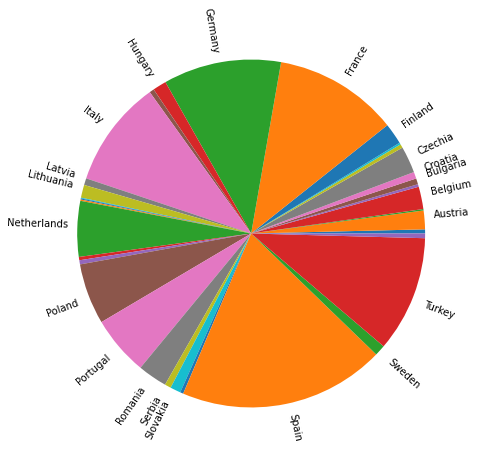

Albania
Belarus
Bosnia and Herzegovina
Bulgaria
Estonia
Iceland
Latvia
Lithuania
Luxembourg
Malta
Moldova, Republic of
Montenegro
North Macedonia
Serbia
Ukraine


,Participants,Community
country,,
Albania,4,3.0
Austria,2659,2609.0
Belarus,14,14.0
Belgium,4166,4040.0
Bosnia and Herzegovina,212,203.0
Bulgaria,352,338.0
Croatia,742,712.0
Czechia,2380,2322.0
Denmark,2219,2112.0


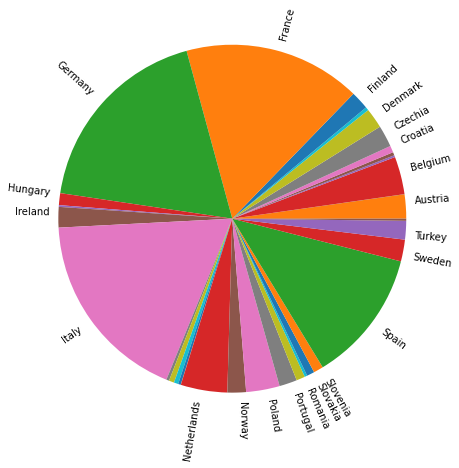

Belarus
Moldova, Republic of
Portugal
Slovenia
Ukraine


,Participants,Community
country,,
Albania,31,56.0
Austria,202,402.0
Belarus,4,4.0
Belgium,269,512.0
Bulgaria,58,112.0
Czechia,267,526.0
Denmark,169,330.0
Estonia,132,264.0
Finland,54,108.0


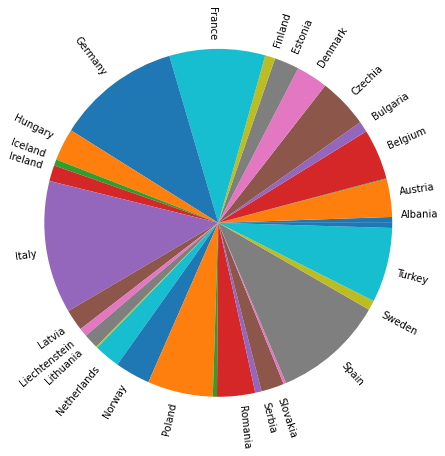

Belarus
Estonia
Finland
Iceland
Montenegro
Netherlands
North Macedonia
Norway
Serbia
Sweden


,Participants,Community
country,,
Albania,54,135.0
Austria,69,180.0
Belarus,15,45.0
Belgium,85,246.0
Bulgaria,61,147.0
Czechia,36,99.0
Estonia,12,36.0
Finland,3,9.0
France,168,486.0


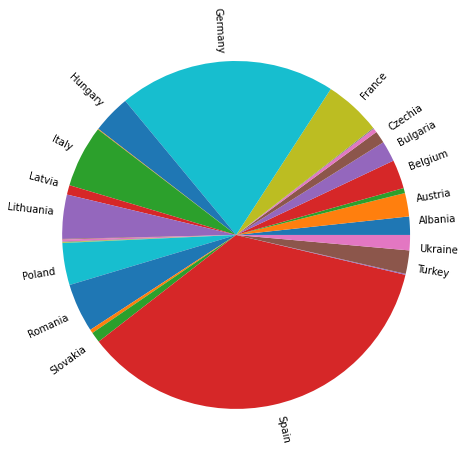

Albania
Belgium
Croatia
Hungary
Montenegro
North Macedonia
Portugal
Romania
Slovenia


,Participants,Community
country,,
Albania,4,12.0
Austria,180,684.0
Belarus,26,96.0
Belgium,8,28.0
Bosnia and Herzegovina,41,148.0
Bulgaria,23,92.0
Croatia,1,4.0
Czechia,417,1620.0
Denmark,57,220.0


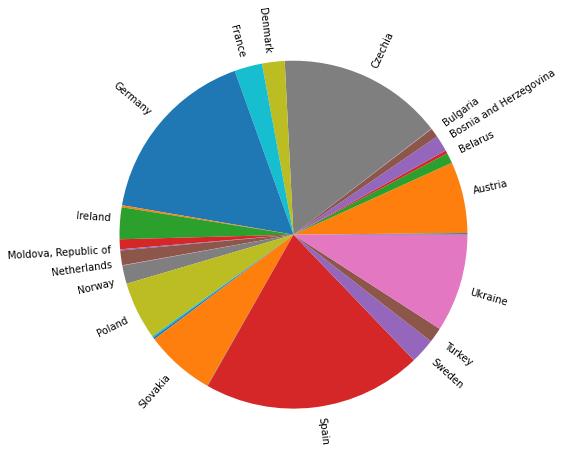

,Participants,Community
country,,
Albania,11,45.0
Belarus,3,15.0
Croatia,2,10.0
France,6,30.0
Germany,9,45.0
Hungary,4,20.0
Lithuania,97,455.0
"Moldova, Republic of",6,30.0
Romania,113,515.0


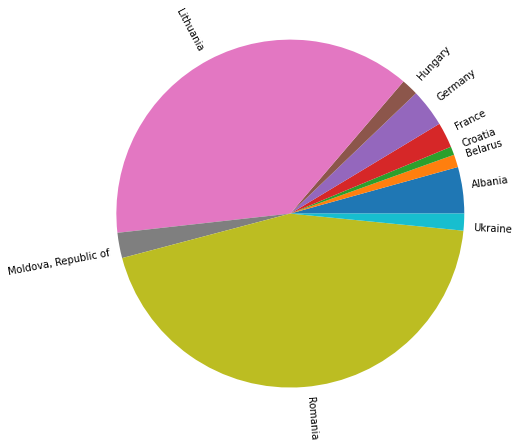

In [20]:
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']


node_comm = nodes_df.copy()
#node_comm.drop(columns=['NodeID'], inplace=True)
node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
temp = uni19_df.loc[:,['Sending Country Code','Sending Organization','Participants']]
temp.rename(columns={'Sending Organization':'Source','Sending Country Code':'country'}, inplace=True)
node_comm = pd.merge(temp,node_comm,how='inner',on='Source')
node_comm = node_comm[node_comm['country'].str.contains('|'.join(eu_countries))==True]
for i, set in enumerate(p):
    if(len(node_comm[node_comm['Community']==i].index)>100):
        display(node_comm[node_comm['Community']==i])


for i, set in enumerate(p):
    if(len(node_comm[node_comm['Community']==i].index)>100):
        com_df = node_comm[node_comm['Community']==i]
        #com_df.drop(columns=['Community'],inplace=True)
        label = com_df.groupby(['country']).sum().index.get_level_values('country').tolist()
        com_df = com_df.groupby(['country']).sum()
        for l,j in enumerate(label):
            if((com_df.loc[j,'Participants']/com_df['Participants'].sum())<0.005):
                print(j)
                label[l]=''
        display(com_df)
        values = com_df['Participants']
        #com_df = com1_df['Quantity']/1318*100
        plt.pie(values,labels= label, labeldistance=1.05,radius=2, rotatelabels=True)
        plt.show()

# 52 communities. Choose if it makes sense to reduce the number of them 


percentage of foreign languages speaker in europe

In [10]:
language_df = pd.read_csv('data\edat_aes_l26_1_Data.csv', sep=',',low_memory=False, header=0, encoding='utf8')
lan_df = language_df[language_df['TIME']==2016]
l = language_df[language_df['TIME']==2007]
l = l[l['GEO']=='Turkey']
lan_df = lan_df.append(l)
lan_df = lan_df[lan_df['DEG_URB']=='Cities']
lan_df = lan_df[~lan_df['N_LANG'].str.contains('No language')]
lan_df.drop(columns=['TIME','DEG_URB','N_LANG','UNIT','Flag and Footnotes'], inplace= True)
lan_df['Value'] = pd.to_numeric(lan_df['Value'], errors='coerce')
lan_df = lan_df.groupby(['GEO']).sum()
lan_df

,Value
GEO,
Albania,55.0
Austria,93.7
Belgium,81.9
Bosnia and Herzegovina,50.9
Bulgaria,64.3
Croatia,83.2
Cyprus,93.0
Czechia,83.8
Denmark,96.7


In [11]:
uni19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(uni19_df)

TypeError: 'frozenset' object is not callable